In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import make_uniform, make_joint, make_joint3, plot_contour, compute_probs

In [4]:
N, K, n, k = 100, 23, 19, 4
ks = np.arange(12)
ps = ss.hypergeom(N, K, n).pmf(ks)
ps

array([3.83666200e-03, 2.84173101e-02, 9.37771233e-02, 1.82942257e-01,
       2.36054525e-01, 2.13573142e-01, 1.40157374e-01, 6.80764389e-02,
       2.47550687e-02, 6.77377501e-03, 1.39460074e-03, 2.14977979e-04])

In [15]:
qs = np.arange(51, 501)
prior_N = make_uniform(qs, name='N')
Ns = prior_N.qs
likelihood = ss.hypergeom(Ns, K, n).pmf(k)
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.07771333079658613

(109, 173.81672819846642, array([ 77., 363.]))

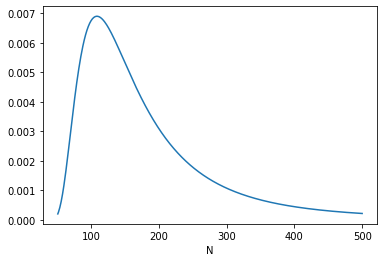

In [16]:
posterior_N.plot()
posterior_N.max_prob(), posterior_N.mean(), posterior_N.credible_interval(0.9)

In [18]:
N = 100
K, n, k = 23, 19, 4
k10 = K - k
k01 = n - k
k11 = k
observed = k10 + k01 + k11
k00 = N - observed
x = [k00, k01, k10, k11]

In [19]:
p = 0.2
q = 1 - p
y = [q*q, q*p, p*q, p*p]

In [20]:
# N과 p을 알고 있는 경우의 likelihood → 모를 경우 두 파라미터에 사전분포를 걸어야
likelihood = ss.multinomial(N, y).pmf(x)
likelihood

0.0016664011988507257

In [22]:
qs_N = np.arange(50, 501)
prior_N = make_uniform(qs_N, name='N')
qs_p = np.linspace(0, 0.99, 100)
prior_p = make_uniform(qs_p, name='p')
prior = make_joint(prior_p, prior_N)
joint_pmf = Pmf(prior.stack())
joint_pmf.head(5)

50  0.00    0.000022
    0.01    0.000022
    0.02    0.000022
    0.03    0.000022
    0.04    0.000022
Name: , dtype: float64

In [23]:
likelihood = joint_pmf.copy()
observed = k01 + k10 + k11
for N, p in joint_pmf.copy().index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1 - p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = ss.multinomial(N, y).pmf(x)

In [24]:
posterior = joint_pmf * likelihood
posterior.normalize()
joint_posterior = posterior.unstack()
joint_posterior

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
50,0.0,6.936668e-60,1.693097e-47,2.323608e-40,2.251960e-35,1.442178e-31,1.652257e-28,5.760210e-26,8.390407e-24,6.264635e-22,...,1.487630e-35,5.249448e-38,8.966390e-41,6.113357e-44,1.254446e-47,4.999900e-52,1.858578e-57,1.628378e-64,1.533008e-74,8.146814e-92
51,0.0,2.667154e-59,6.379120e-47,8.576956e-40,8.141980e-35,5.106143e-31,5.727435e-28,1.954479e-25,2.786028e-23,2.035192e-21,...,5.836088e-37,1.668113e-39,2.251254e-42,1.175175e-45,1.771664e-49,4.903748e-54,1.166615e-59,5.749427e-67,2.405644e-77,3.196058e-95
52,0.0,9.709432e-59,2.275560e-46,2.997450e-39,2.787070e-34,1.711652e-30,1.879711e-27,6.278736e-25,8.758636e-23,6.259843e-21,...,2.167690e-38,5.018637e-41,5.351551e-44,2.138819e-47,2.368968e-51,4.553480e-56,6.933029e-62,1.921951e-69,3.574100e-80,1.187107e-98
53,0.0,3.362396e-58,7.721915e-46,9.965063e-39,9.075591e-34,5.458173e-30,5.868559e-27,1.918769e-24,2.619369e-22,1.831601e-20,...,7.659171e-40,1.436334e-42,1.210164e-45,3.703009e-49,3.013327e-53,4.022241e-58,3.919472e-64,6.111805e-72,5.051394e-83,4.194445e-102
54,0.0,1.112226e-57,2.502943e-45,3.164443e-38,2.822872e-33,1.662525e-29,1.750092e-26,5.600959e-24,7.482491e-22,5.119027e-20,...,2.584970e-41,3.926578e-44,2.613954e-47,6.123851e-51,3.661192e-55,3.393766e-60,2.116515e-66,1.856461e-74,6.819382e-86,1.415625e-105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.0,8.742606e-18,2.490220e-09,3.634514e-06,3.407196e-05,1.915893e-05,1.745900e-06,4.376479e-08,4.134486e-10,1.801831e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
497,0.0,9.278014e-18,2.589606e-09,3.702827e-06,3.400034e-05,1.872243e-05,1.670394e-06,4.098590e-08,3.789142e-10,1.615625e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
498,0.0,9.844574e-18,2.692510e-09,3.771798e-06,3.392323e-05,1.829283e-05,1.597887e-06,3.837707e-08,3.472066e-10,1.448421e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
499,0.0,1.044400e-17,2.799040e-09,3.841418e-06,3.384070e-05,1.787013e-05,1.528275e-06,3.592836e-08,3.180997e-10,1.298307e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


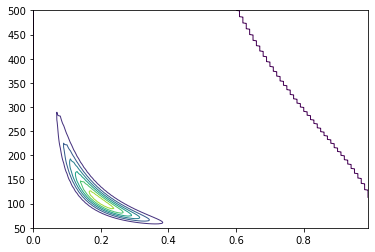

In [25]:
plot_contour(joint_posterior)

In [26]:
posterior_p2 = posterior.marginal(1)
posterior_N2 = posterior.marginal(0)

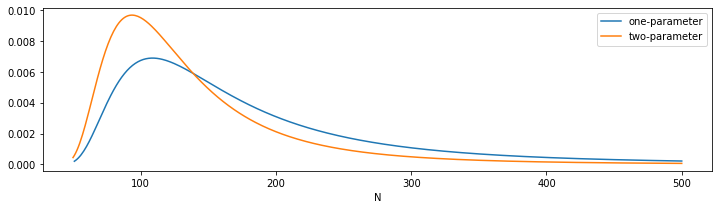

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
posterior_N.plot(ax=ax, label='one-parameter')
posterior_N2.plot(ax=ax, label='two-parameter')
plt.legend()
plt.show()